# Dynamic Forecasting Experiment
Dieses Notebook enthält den Code zu den Forcasting Experimenten.


## Imports

In [1]:
#Imports
from google.colab import drive
# Mount Google Drive to access files
drive.mount('/content/drive')
# Install required libraries
!pip install ema-pytorch==0.2.1;pandas==1.5.0;scikit-learn==1.1.2;scipy==1.8.1;seaborn==0.12.2;tqdm==4.64.1;dm-control==1.0.12;dm-env==1.6;dm-tree==0.1.8;mujoco==2.3.4;gluonts==0.12.6;pyyaml==6.0
import os
import torch
import numpy as np
import sys

# Add the project directory to the system path
sys.path.insert(0,'/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS')
# Import custom modules
from engine.solver import Trainer
from Utils.metric_utils import visualization
from Data.build_dataloader import build_dataloader
from Utils.io_utils import load_yaml_config, instantiate_from_config
from Models.interpretable_diffusion.model_utils import unnormalize_to_zero_to_one

from Utils.metric_utils import display_scores
from Utils.discriminative_metric import discriminative_score_metrics
from Utils.predictive_metric import predictive_score_metrics

import itertools
import yaml
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from Utils.cross_correlation import CrossCorrelLoss
# Install gluonts (again, just to be sure)
!pip install gluonts

import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

# Import additional libraries for data processing and model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from Models.interpretable_diffusion.model_utils import normalize_to_neg_one_to_one

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/bin/bash: line 1: scikit-learn==1.1.2: command not found
/bin/bash: line 1: dm-control==1.0.12: command not found
/bin/bash: line 1: dm-env==1.6: command not found
/bin/bash: line 1: dm-tree==0.1.8: command not found


## Data Pre Processing

In [2]:
data_real = np.load('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/grid_search/Augmentiert/macro_germany_a_relative/batch_size64_n_heads4_d_model64_timestamp200/samples/macro_ground_truth_24_train.npy')
data_real = np.array(data_real)

In [ ]:
'''import pandas as pd
csv_file_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro_augemented.csv'
df_macro = pd.read_csv(csv_file_path)
df_macro_relative_change = df_macro.pct_change().dropna()

'''


"import pandas as pd\ncsv_file_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro_augemented.csv'\ndf_macro = pd.read_csv(csv_file_path)\ndf_macro_relative_change = df_macro.pct_change().dropna()\n\n"

In [ ]:
'''def create_overlapping_sequences(data, seq_length):
    """
    Creates overlapping sequences from time series data.

    Args:
        data (np.ndarray): The input time series data (2D array).
        seq_length (int): The desired length of each sequence.

    Returns:
        np.ndarray: A 3D array containing the overlapping sequences.
    """
    num_samples = data.shape[0]
    num_features = data.shape[1]
    num_sequences = num_samples - seq_length + 1
    overlapping_sequences = np.zeros((num_sequences, seq_length, num_features))

    for i in range(num_sequences):
        overlapping_sequences[i, :, :] = data[i : i + seq_length, :]

    return overlapping_sequences

# Convert the relative change DataFrame to a NumPy array
data_relative_change = df_macro_relative_change.values

# Define the sequence length (assuming seq_length is already defined)
# If not, you'll need to define it here, e.g., seq_length = 24

# Create overlapping sequences
overlapping_data_relative_change = create_overlapping_sequences(data_relative_change, 24)

print("Shape of the overlapping sequences array:", overlapping_data_relative_change.shape)'''

'def create_overlapping_sequences(data, seq_length):\n    """\n    Creates overlapping sequences from time series data.\n\n    Args:\n        data (np.ndarray): The input time series data (2D array).\n        seq_length (int): The desired length of each sequence.\n\n    Returns:\n        np.ndarray: A 3D array containing the overlapping sequences.\n    """\n    num_samples = data.shape[0]\n    num_features = data.shape[1]\n    num_sequences = num_samples - seq_length + 1\n    overlapping_sequences = np.zeros((num_sequences, seq_length, num_features))\n\n    for i in range(num_sequences):\n        overlapping_sequences[i, :, :] = data[i : i + seq_length, :]\n\n    return overlapping_sequences\n\n# Convert the relative change DataFrame to a NumPy array\ndata_relative_change = df_macro_relative_change.values\n\n# Define the sequence length (assuming seq_length is already defined)\n# If not, you\'ll need to define it here, e.g., seq_length = 24\n\n# Create overlapping sequences\noverlappin

In [3]:
data = data_real

In [4]:
np.shape(data)

(247, 24, 7)

In [4]:
# Split data into training and testing sets
train = data[0:246].reshape(-1, data.shape[-1])
test = data[246:,:,:]
# Initialize MinMaxScaler and scale the training data
scaler = MinMaxScaler()
train_scaled = normalize_to_neg_one_to_one(scaler.fit_transform(train))
# Scale the test data and reshape
test_scaled = scaler.transform(test.reshape(-1, test.shape[-1])).reshape(test.shape)
# Normalize the scaled test data
test_scaled = normalize_to_neg_one_to_one(test_scaled)

print("Shape of test_scaled:", test_scaled.shape)

Shape of test_scaled: (1, 24, 7)


In [5]:
'''# Define a custom Dataset class for the macro data
class MacroDataset(Dataset):
    def __init__(self, data, regular=True, pred_length=4):
        super(MacroDataset, self).__init__()
        # Number of samples
        self.sample_num = data.shape[0]
        # Data samples
        self.samples = data
        # Flag for regular dataset (without mask)
        self.regular = regular
        # Create a mask for the prediction period
        self.mask = np.ones_like(data)
        #self.mask[:, -pred_length:, :] = 0.
        self.mask[:, -4:, :] = 0.   ####Hier 3 oder 4!!!!!!??????
        self.mask[:, -4, 2] = 1.  ######
        self.mask = self.mask.astype(bool)

    def __getitem__(self, ind):
        # Get a sample
        x = self.samples[ind, :, :]
        # Return data without mask if regular
        if self.regular:
            return torch.from_numpy(x).float()
        # Get the corresponding mask
        mask = self.mask[ind, :, :]
        # Return data and mask
        return torch.from_numpy(x).float(), torch.from_numpy(mask)

    def __len__(self):
        # Return the number of samples
        return self.sample_num'''
class MacroDataset(Dataset):
  def __init__(self, data, regular=True, stressed_var = None):
        super(MacroDataset, self).__init__()
        self.sample_num = data.shape[0]
        self.samples = data
        self.regular = regular
        self.mask = np.ones_like(data)
        if not self.regular:
            self.mask[:, -18:, :] = 0.
            #self.mask[:, :-12, stressed_var] = 1. #####
        #print(self.mask)
        self.mask = self.mask.astype(bool)

  def __getitem__(self, ind):
      x = self.samples[ind, :, :]
      if self.regular:
          return torch.from_numpy(x).float()
      mask = self.mask[ind, :, :]
      return torch.from_numpy(x).float(), torch.from_numpy(mask)

  def __len__(self):
      return self.sample_num

In [6]:
# Create a MacroDataset for the training data
train_dataset = MacroDataset(train_scaled.reshape(246, -1, data.shape[-1]))
# Create a DataLoader for the training dataset
dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0, drop_last=True, pin_memory=True, sampler=None)

In [7]:
# Define a class for arguments
class Args_Example:
    def __init__(self) -> None:
        # Path to the configuration file
        self.config_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Config/macro_germany_relative.yaml'
        # Directory to save results
        self.results_folder = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/grid_search/Augmentiert/macro_germany_a_relative'
        # GPU to use
        self.gpu = 0
        # Create save directory if it doesn't exist
        os.makedirs(self.results_folder, exist_ok=True)

# Instantiate arguments
args =  Args_Example()
# Load configuration from the YAML file
configs = load_yaml_config(args.config_path)
# Set the device to GPU if available, otherwise CPU
device = torch.device(f'cuda:{args.gpu}' if torch.cuda.is_available() else 'cpu')

# Instantiate the model from the configuration and move it to the device
model = instantiate_from_config(configs['model']).to(device)
# Initialize the Trainer
trainer = Trainer(config=configs, args=args, model=model, dataloader={'dataloader':dataloader})

## Train or load Model

In [8]:
# Load the model from a saved milestone
trainer.train()#load(milestone = 1)

## Sample

In [9]:
stressed_var = []
shift = 7
#perc_0 = 0.92
#perc_1 = 1.03
#perc_2 = 1.08
#perc_3 = 1.20
#perc_4 = 1.03
#perc_5 = 0.9
#perc_6 = 1.03
seq_length = 24
pred_length = 18
extrem_value = scaler.inverse_transform(unnormalize_to_zero_to_one(test_scaled.reshape(-1, 7))).reshape(test_scaled.shape)
#extrem_value[0,-6:,0 +shift] = extrem_value[0,-6:,0+shift] *np.linspace(1.0, -100, num=6)
#extrem_value[0,:,1] = extrem_value[0,:,1] * perc_1
#extrem_value[0,:,2] = extrem_value[0,:,2] * perc_2
#extrem_value[0,-6:,3+shift] = extrem_value[0,-6:,3+shift] *np.linspace(1.0, 20, num=6)
#extrem_value[0,:,4] = extrem_value[0,:,4] * perc_4
#extrem_value[0,-6:,5+shift] = extrem_value[0,-6:,5+shift] *np.linspace(1.0, -10, num=6)
#extrem_value[0,:,6] = extrem_value[0,:,6] * perc_6
extrem_value_norm = scaler.transform(extrem_value.reshape(-1, test.shape[-1])).reshape(extrem_value.shape)
extrem_value_norm = normalize_to_neg_one_to_one(extrem_value_norm)
unseen =np.zeros_like(test_scaled)
unseen_noStress =np.zeros_like(test_scaled)
unseen[:,:seq_length-pred_length,:] =np.copy( test_scaled[:,pred_length:,:])
unseen_noStress[:,:seq_length-pred_length,:] =np.copy( test_scaled[:,pred_length:,:])
unseen[0,6:13 ,stressed_var] = extrem_value_norm[0,-7:,stressed_var]




In [ ]:

perc = 1.01
seq_length = 24
pred_length = 18
extrem_value = scaler.inverse_transform(unnormalize_to_zero_to_one(test_scaled.reshape(-1, 7))).reshape(test_scaled.shape) * perc
extrem_value_norm = scaler.transform(extrem_value.reshape(-1, test.shape[-1])).reshape(extrem_value.shape)
extrem_value_norm = normalize_to_neg_one_to_one(extrem_value_norm)
unseen_noStress =np.zeros_like(test_scaled)
unseen_noStress[:,:seq_length-pred_length,:] =np.copy( test_scaled[:,pred_length:,:])
unseen_noStress[0,6:12 ,stressed_var] = extrem_value_norm[0,-1,stressed_var]

ValueError: operands could not be broadcast together with shapes (48,7) (14,) (48,7) 

In [10]:
unseen


array([[[ 0.89143944, -0.84016607,  0.92369478,  0.08545035,
         -0.97963893,  0.38617406, -0.82234186],
        [ 0.900739  , -0.82559994,  0.94779116,  0.11778291,
         -0.97991041,  0.32241478, -0.80248991],
        [ 0.90831748, -0.81220131,  0.96787149,  0.12240185,
         -0.94326049,  0.37055799, -0.66991925],
        [ 0.9099828 , -0.80193533,  0.99196787,  0.16397229,
         -0.99158409,  0.49822891, -0.53297443],
        [ 0.90270037, -0.79504966,  1.        ,  0.15011547,
         -0.99538482,  0.41984384, -0.51144011],
        [ 0.88392553, -0.79154741,  1.00401606,  0.15935335,
         -0.98886928,  0.46791087, -0.43135935],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ],
        [ 

In [11]:
# Get sequence length and feature number from the test data shape
_, seq_length, feat_num =  unseen.shape



test_dataset = MacroDataset(unseen, regular=False, stressed_var= stressed_var)
real = scaler.inverse_transform(unnormalize_to_zero_to_one(unseen.reshape(-1, feat_num))).reshape(unseen.shape)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=unseen.shape[0], shuffle=True, num_workers=0, pin_memory=True, sampler=None)

# Restore (sample) from the trained model
samples = []
for _ in range(1):
    sample, *_ = trainer.restore(test_dataloader, shape=[seq_length, feat_num], coef=1e-1, stepsize=1e-1, sampling_steps=200)
    samples.append(sample)
    #print(sample[:,:,0])
sample = np.concatenate(samples, axis=0)
# Inverse scale and unnormalize the generated samples to get the real values
sample = scaler.inverse_transform(unnormalize_to_zero_to_one(sample.reshape(-1, feat_num))).reshape(-1, unseen.shape[1], unseen.shape[2])

conditional sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
# Get sequence length and feature number from the test data shape
_, seq_length, feat_num = unseen_noStress.shape

# Create a MacroDataset for the test data with masking for the prediction period
# regular=True is used here, but the dataset will still return a mask
test_dataset = MacroDataset(unseen_noStress, regular=False, stressed_var = stressed_var)
# Inverse scale and unnormalize the test data to get the real values
real = scaler.inverse_transform(unnormalize_to_zero_to_one(unseen_noStress.reshape(-1, feat_num))).reshape(unseen_noStress.shape)
# Create a DataLoader for the test dataset
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=unseen_noStress.shape[0], shuffle=False, num_workers=0, pin_memory=True, sampler=None)

# Restore (sample) from the trained model
samples_noStress = []
for _ in range(1):
    # trainer.restore now expects two outputs (sample and mask)
    sample_noStress, mask_noStress, *_ = trainer.restore(test_dataloader, shape=[seq_length, feat_num], coef=1e-1, stepsize=1e-1, sampling_steps=200)
    samples_noStress.append(sample_noStress)

sample_noStress = np.concatenate(samples_noStress, axis=0)

# Inverse scale and unnormalize the generated samples to get the real values
sample_noStress = scaler.inverse_transform(unnormalize_to_zero_to_one(sample_noStress.reshape(-1, feat_num))).reshape(-1, unseen_noStress.shape[1], unseen_noStress.shape[2])

In [24]:

# Function to convert relative changes back to original
def relative_change_to_original(relative_changes, initial_values):
    original_values = np.zeros_like(relative_changes)

    original_values[:, 0, :] = initial_values * (relative_changes[:, 0, :] +1)

    for i in range(1, relative_changes.shape[1]):
        original_values[:, i, :] = original_values[:, i-1, :] * (relative_changes[:, i, :]+1 )
    return original_values

# Use last_seq_value as the initial values for the conversion
initial_values_for_conversion = data_real[-1,-1,:]

# Convert sample and sample_noStress back to original scale
sample_original = relative_change_to_original(sample, initial_values_for_conversion)
#sample_noStress_original = relative_change_to_original(sample_noStress, initial_values_for_conversion)

print("Sample original shape:", sample_original.shape)
#print("Sample no stress original shape:", sample_noStress_original.shape)
'''# Function to convert relative changes back to original
def relative_change_to_original(relative_changes, initial_values):
    original_values = np.copy(relative_changes) # Create a copy to avoid modifying the input

    # Only transform the last 7 features
    original_values[:, 0, -7:] = initial_values[:7] * (relative_changes[:, 0, -7:] + 1)

    for i in range(1, relative_changes.shape[1]):
        original_values[:, i, -7:] = original_values[:, i-1, -7:] * (relative_changes[:, i, -7:] + 1)

    return original_values

# Use last_seq_value as the initial values for the conversion
initial_values_for_conversion = data_real[-1,-1,:]

# Convert sample back to original scale (only the last 7 features will be transformed)
sample_original = relative_change_to_original(sample, initial_values_for_conversion)
#sample_noStress_original = relative_change_to_original(sample_noStress, initial_values_for_conversion)


print("Sample original shape:", sample_original.shape)'''
#print("Sample no stress original shape:", sample_noStress_original.shape)

Sample original shape: (1, 24, 7)


'# Function to convert relative changes back to original\ndef relative_change_to_original(relative_changes, initial_values):\n    original_values = np.copy(relative_changes) # Create a copy to avoid modifying the input\n\n    # Only transform the last 7 features\n    original_values[:, 0, -7:] = initial_values[:7] * (relative_changes[:, 0, -7:] + 1)\n\n    for i in range(1, relative_changes.shape[1]):\n        original_values[:, i, -7:] = original_values[:, i-1, -7:] * (relative_changes[:, i, -7:] + 1)\n\n    return original_values\n\n# Use last_seq_value as the initial values for the conversion\ninitial_values_for_conversion = data_real[-1,-1,:]\n\n# Convert sample back to original scale (only the last 7 features will be transformed)\nsample_original = relative_change_to_original(sample, initial_values_for_conversion)\n#sample_noStress_original = relative_change_to_original(sample_noStress, initial_values_for_conversion)\n\n\nprint("Sample original shape:", sample_original.shape)'

In [25]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd
import numpy as np
import os

feature_names = ['GDP', 'Unemployment', 'Inflation', 'InterestRate', 'Swiss franc/Euro', 'Euro/Dollar', 'Euro/UK']

plt.rcParams["font.size"] = 12

# Number of historical sequences to plot (this now determines the length of the history from df_macro)
num_history_sequences = 8
seq_length = 24 # Assuming seq_length is defined elsewhere and available
history_plot_points = num_history_sequences * seq_length # Total number of data points to plot from history
df_macro = pd.read_csv('/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro_augemented.csv')
# Get the relevant historical data from df_macro
historical_df = df_macro.iloc[-history_plot_points-1:]

# Specify the output folder and PDF file name
output_folder = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Plots/' # You can change the folder here
test_name = "Normales_Forcasting" #Bekannte Seq - Variable - Stress - Datenpunkte gestresst - Sequenzen
output_pdf_path = os.path.join(output_folder, f'{test_name}.pdf') # You can change the filename here

# Create the output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

with PdfPages(output_pdf_path) as pdf:
    for idx in range(feat_num): # Assuming feat_num is defined elsewhere and available
        plt.figure(figsize=(15, 3))

        plt.plot(range(history_plot_points + 1) ,
                historical_df.iloc[:, idx ],
                linestyle='dashed', color='green', label='Historical Data')

        # Plot the generated samples starting with an overlap of 6 points
        overlap = 6
        for i in range(sample.shape[0]):
            plt.plot(range(history_plot_points + 1 - overlap, history_plot_points + 1 + seq_length - overlap),
                     sample_original[i, :, idx],
                     linestyle='solid', label=f'Sample {i+1}', color='red', alpha=0.5)

        # Plot the "sample no stress" starting with an overlap of 6 points
        #plt.plot(range(history_plot_points + 1 - overlap, history_plot_points + 1 + seq_length - overlap),
         #        sample_original[0, :, idx],
          #       linestyle='solid', label=f'Sample no Stress', color='blue')


        plt.tick_params('both', labelsize=15)
        plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
        #plt.legend()
        plt.title(f'Sample for {feature_names[idx]}')
        pdf.savefig()  # Save the current figure to the PDF
        plt.close() # Close the figure to free memory

print(f"Plots saved to {output_pdf_path}")

# Save the generated samples as numpy files
sample_output_path = os.path.join(output_folder, f'{test_name}.npy')


np.save(sample_output_path, sample)


print(f"Generated samples saved to {sample_output_path}")

Plots saved to /content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Plots/Normales_Forcasting.pdf
Generated samples saved to /content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Plots/Normales_Forcasting.npy


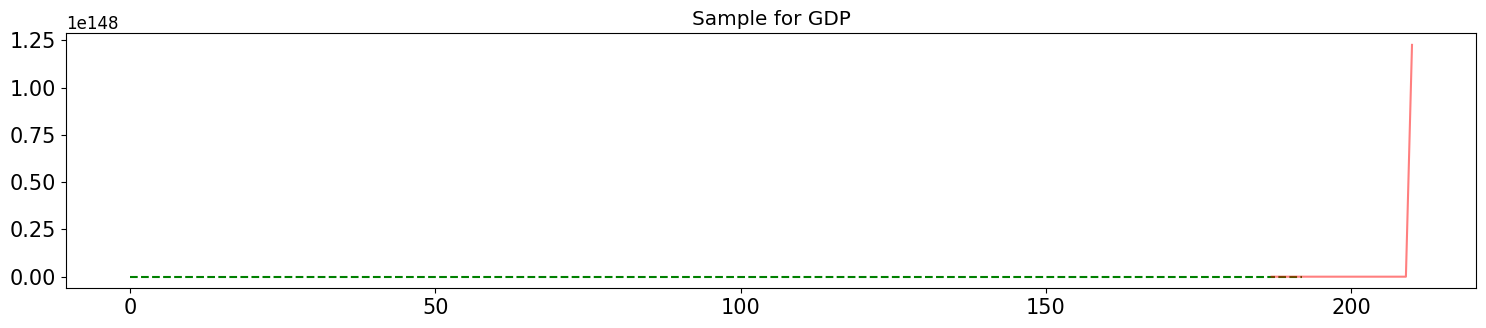

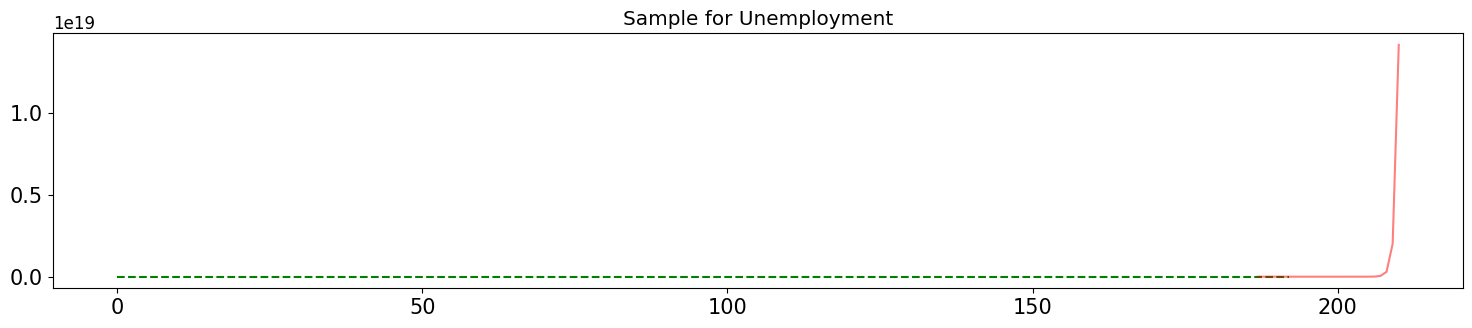

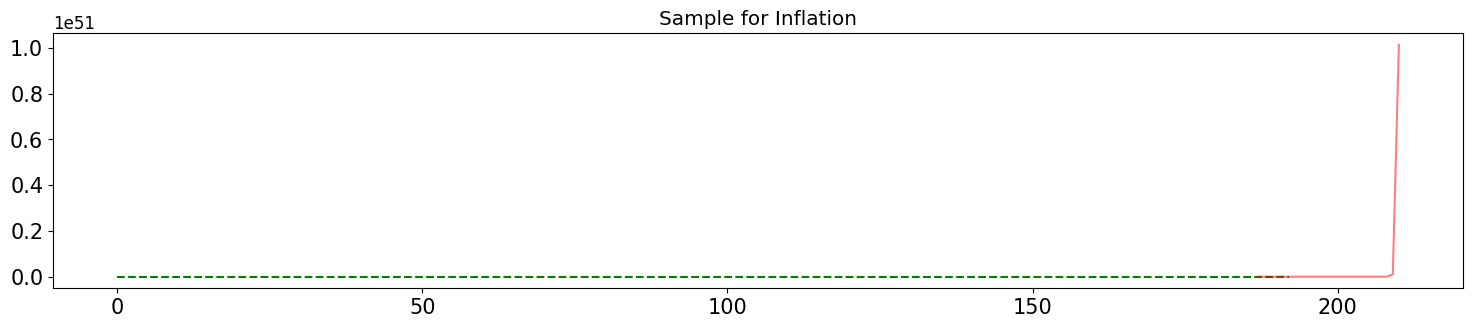

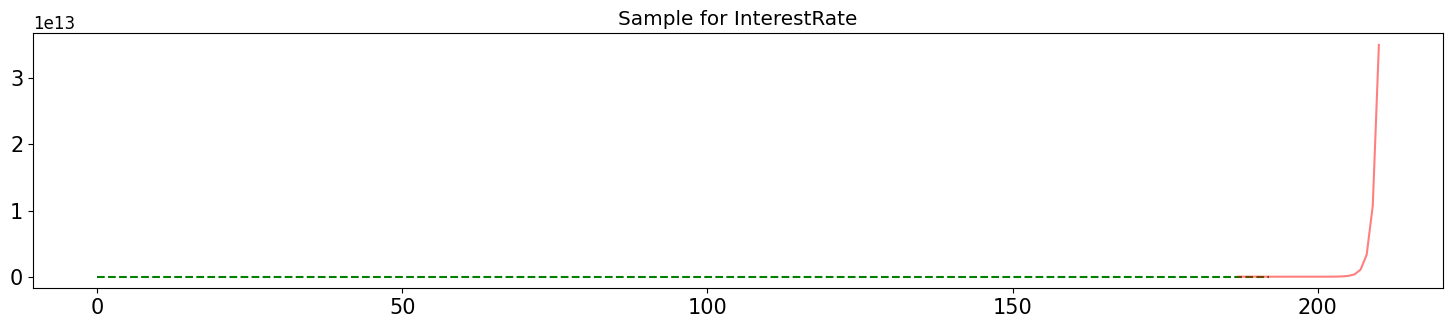

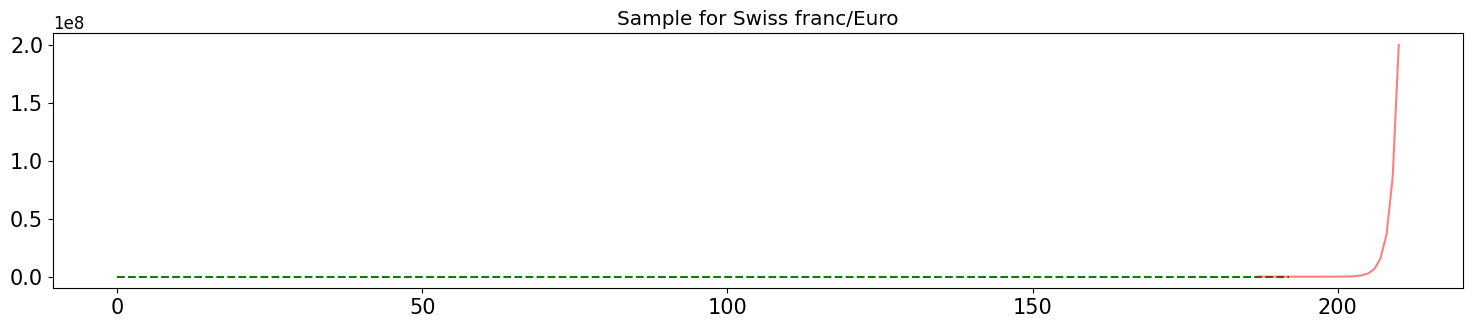

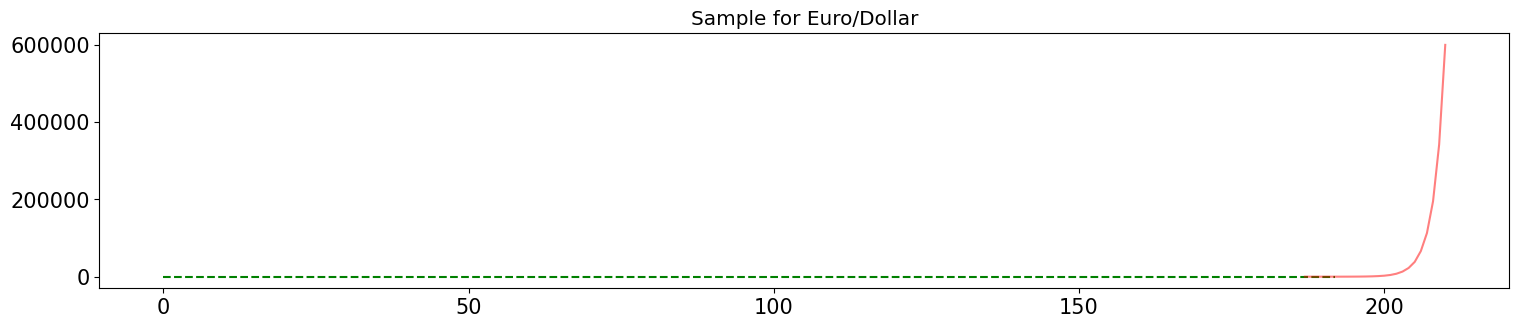

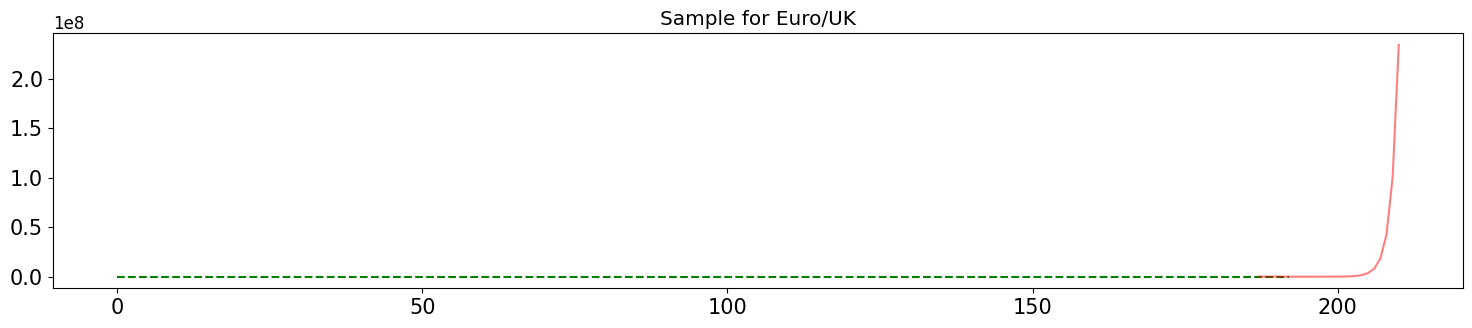

In [26]:
for idx in range(feat_num): # Assuming feat_num is defined elsewhere and available
        plt.figure(figsize=(15, 3))


        plt.plot(range(history_plot_points + 1) ,
                historical_df.iloc[:, idx ],
                linestyle='dashed', color='green', label='Historical Data')

        # Plot the generated samples starting with an overlap of 6 points

        overlap = 6
        for i in range(sample.shape[0]):
            plt.plot(range(history_plot_points + 1 - overlap, history_plot_points + 1 + seq_length - overlap),
                     sample_original[i, :, idx],
                     linestyle='solid', label=f'Sample {i+1}', color='red', alpha=0.5)

        # Plot the "sample no stress" starting with an overlap of 6 points
        #plt.plot(range(history_plot_points + 1 - overlap, history_plot_points + 1 + seq_length - overlap),
         #        sample_noStress[0, :, idx],
          #       linestyle='solid', label=f'Sample no Stress', color='blue')


        plt.tick_params('both', labelsize=15)
        plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
        #plt.legend()
        plt.title(f'Sample for {feature_names[idx]}')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix for each historical sequence and average
correlation_matrices_real = []
for i in range(data_real.shape[0]):
    df_sequence = pd.DataFrame(data_real[i, :, :])
    correlation_matrices_real.append(df_sequence.corr().values)

average_correlation_matrix_real = np.mean(correlation_matrices_real, axis=0)

# Plot the average historical correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(average_correlation_matrix_real, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Correlation Matrix of Historical Sequences')
plt.show()


# Calculate correlation matrix for each generated sequence and average
correlation_matrices_sample = []
for i in range(sample_original.shape[0]):
    df_sequence = pd.DataFrame(sample_original[i, :, :])
    correlation_matrices_sample.append(df_sequence.corr().values)

average_correlation_matrix_sample = np.mean(correlation_matrices_sample, axis=0)


# Plot the average generated sample correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(average_correlation_matrix_sample, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Average Correlation Matrix of Generated Sequences')
plt.show()

# Calculate and plot the difference between average correlation matrices
correlation_difference_matrix_avg = average_correlation_matrix_sample - average_correlation_matrix_real


# Plot the difference between average correlation matrices as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_difference_matrix_avg, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Difference between Average Correlation Matrices (Generated - Historical)')
plt.show()

## Plott

In [ ]:
import matplotlib.pyplot as plt

feature_names = ['GDP', 'Unemployment', 'Inflation', 'InterestRate', 'Swiss franc/Euro', 'Euro/Dollar', 'Euro/US change']

plt.rcParams["font.size"] = 12

display_length = 8

for idx in range(feat_num):

    plt.figure(figsize=(10, 3))

    for i in range(sample.shape[0]):
        plt.plot(range(seq_length - display_length, seq_length), sample[i, -display_length:, idx], linestyle='solid', label=f'Sample {i+1}',color = 'red', alpha = 0.5 )
    plt.plot(range(seq_length - display_length, seq_length), sample_noStress[0, -display_length:, idx], linestyle='solid', label=f'Sample no Stress',color = 'blue')
    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    #plt.legend()
    plt.title(f'Sample for {feature_names[idx]}')
    plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the path to the CSV file
csv_file_path = '/content/drive/MyDrive/Project: Diffusion-TS/Diffusion-TS/Data/germany_macro.csv'

# Read the CSV file into a pandas DataFrame
try:
    df_macro = pd.read_csv(csv_file_path)

    # Plot each column as a separate time series
    for column in df_macro.columns:
        plt.figure(figsize=(12, 4)) # Adjust figure size as needed
        plt.plot(df_macro.index, df_macro[column], label=column)
        plt.title(f'Time Series Data for {column}')
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Calculate and plot relative changes for each column
    df_macro_relative_change = df_macro.pct_change().dropna()

    for column in df_macro_relative_change.columns:
        plt.figure(figsize=(12, 4)) # Adjust figure size as needed
        plt.plot(df_macro_relative_change.index, df_macro_relative_change[column], label=f'{column} Relative Change')
        plt.title(f'Relative Change for {column}')
        plt.xlabel('Time')
        plt.ylabel('Relative Change')
        plt.legend()
        plt.grid(True)
        plt.show()


except FileNotFoundError:
    print(f"Error: The file '{csv_file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [ ]:
import numpy as np
from typing import Optional, Sequence, Dict

def maha_scores_joint(
    data: np.ndarray,
    sample: np.ndarray,
    *,
    shrinkage: float = 0.1,
    feature_names: Optional[Sequence[str]] = None,
    time_index: Optional[Sequence] = None,
    return_extra: bool = True,
    tail_quantile: float = 0.95,
) -> Dict[str, np.ndarray]:
    """
    Berechnet verschiedene Plausibilitäts- und Extremheits-Scores
    für generierte Sequenzen im Vergleich zur Historie.

    Parameter
    ---------
    data   : ndarray (n_hist, T, F)
        Historische Sequenzen
    sample : ndarray (n_gen,  T, F)
        Generierte Sequenzen (gleiches T,F)
    shrinkage : float
        Shrinkage für Kovarianz
    tail_quantile : float
        Quantils-Schwelle für Tail-Events (z. B. 0.95)

    Returns
    -------
    results : dict mit Arrays (shape = (n_gen,))
        Enthält Scores wie:
        - 'maha'   : Mahalanobis-Distanz (gemeinsam)
        - 'corr'   : Distanz der Korrelationsmatrix (Frobenius)
        - 'tail'   : Anteil gleichzeitiger Tail-Events
        - 'extrem' : max. Abweichung von historischem Mittel (z-Score)
    """

    n_hist, T, F = data.shape
    n_gen, T2, F2 = sample.shape
    assert (T, F) == (T2, F2), "data und sample müssen gleiche (T,F) haben."

    # Mittelwert und Kovarianz
    mu = data.mean(axis=0)  # (T,F)
    H = (data - mu[None, :, :]).reshape(n_hist, -1)
    P = T * F

    # --- Kovarianzmatrix + Inverse vorbereiten ---
    S = (H.T @ H) / max(1, (n_hist - 1))
    # Shrinkage
    S = (1 - shrinkage) * S + shrinkage * np.trace(S) / P * np.eye(P)
    # Fallback falls singulär
    if np.linalg.cond(S) > 1e12:
        S = S + 1e-6 * np.eye(P)
    S_inv = np.linalg.pinv(S)

    def maha(vec: np.ndarray) -> float:
        return float(vec.T @ S_inv @ vec)

    # --- historische Referenzen ---
    hist_corr = np.corrcoef(data.reshape(-1, F), rowvar=False)
    q_hi = np.quantile(data, tail_quantile, axis=0)
    q_lo = np.quantile(data, 1-tail_quantile, axis=0)

    # --- Scores Container ---
    maha_scores = np.zeros(n_gen)
    corr_scores = np.zeros(n_gen)
    tail_scores = np.zeros(n_gen)
    extrem_scores = np.zeros(n_gen)

    for i in range(n_gen):
        d = (sample[i] - mu).reshape(-1)  # Flatten
        maha_scores[i] = maha(d)

        # Korrelationsdistanz
        corr_i = np.corrcoef(sample[i], rowvar=False)
        corr_scores[i] = np.linalg.norm(corr_i - hist_corr, ord="fro")

        # Tail-Events: Anteil Punkte außerhalb historischer 95%-Bandbreite
        upper = (sample[i] > q_hi).sum()
        lower = (sample[i] < q_lo).sum()
        tail_scores[i] = (upper + lower) / (T * F)

        # Extremheits-Score: größter z-Wert
        sigma = data.std(axis=0)
        z_scores = np.abs((sample[i] - mu) / (sigma + 1e-6))
        extrem_scores[i] = float(np.max(z_scores))

    results = dict(
        maha=maha_scores,
        corr=corr_scores,
        tail=tail_scores,
        extrem=extrem_scores,
    )

    # Index der "extremsten" Sequenz pro Score
    if return_extra:
        results["idx_maha"] = int(np.argmax(maha_scores))
        results["idx_corr"] = int(np.argmax(corr_scores))
        results["idx_tail"] = int(np.argmax(tail_scores))
        results["idx_extrem"] = int(np.argmax(extrem_scores))

    return results


import numpy as np

import numpy as np

def rank_scenarios_stress(
    scores: dict,
    flip_corr: bool = True,
    quantile: float = 0.01,
):
    """
    Aggregiert Rankings aus mehreren Metriken zu einem Gesamtranking.
    Zusätzlich werden die Top-Szenarien im Quantil-Bereich, die
    gestresstesten Szenarien je Metrik und die unzulässigen Szenarien
    ausgegeben.

    Parameter
    ---------
    scores : dict
        Keys: 'maha', 'corr', 'tail', 'extrem' (Arrays gleicher Länge).
    flip_corr : bool
        Wenn True, wird 'corr' so behandelt, dass kleinere Werte = besser sind.
    quantile : float
        Unteres und oberes Quantil für Zulässigkeit (default 1% / 99%).

    Returns
    -------
    results : dict mit
        - "ranking_valid": Indices der Top-Szenarien im Quantil-Bereich
        - "worst_in_metric": dict mit Index der gestresstesten Reihe je Metrik
        - "invalid": Indices der nicht-zulässigen Szenarien
        - "rank_table": Einzelränge pro Metrik
        - "agg_ranks": Aggregierte Ränge
        - "mask_realistic": Bool-Maske gültiger Szenarien
    """
    n = len(scores["maha"])
    metrics = ["maha", "corr", "tail", "extrem"]

    rank_table = {}
    mask_realistic = np.ones(n, dtype=bool)

    for m in metrics:
        vals = np.array(scores[m], dtype=float)
        if m == "corr" and flip_corr:
            order = np.argsort(vals)  # kleiner = besser
        else:
            order = np.argsort(-vals) # größer = besser

        # Ränge speichern
        ranks = np.empty_like(order)
        ranks[order] = np.arange(n)
        rank_table[m] = ranks

        # Quantil-Schranken
        q_low, q_high = np.quantile(vals, [quantile, 1-quantile])
        mask_realistic &= (vals >= q_low) & (vals <= q_high)

    # Aggregation: mittlerer Rang
    agg_ranks = np.mean([rank_table[m] for m in metrics], axis=0)
    agg_ranks[~mask_realistic] = np.inf  # bestrafen

    # Gesamtranking (kleiner = besser)
    final_ranking = np.argsort(agg_ranks)

    # 1. Ranking nur gültige Szenarien
    ranking_valid = [i for i in final_ranking if mask_realistic[i]]

    # 2. Gestressteste Szenarien je Metrik (nur innerhalb gültiger!)
    worst_in_metric = {}
    for m in metrics:
        vals = np.array(scores[m], dtype=float)
        if m == "corr" and flip_corr:
            # hier: größter Wert = schlechtester (weil kleiner = besser)
            worst_idx = np.argmax(vals * mask_realistic)
        else:
            worst_idx = np.argmax(vals * mask_realistic)
        worst_in_metric[m] = int(worst_idx)

    # 3. Nicht-zulässige
    invalid = np.where(~mask_realistic)[0].tolist()

    return dict(
        ranking_valid=ranking_valid,
        worst_in_metric=worst_in_metric,
        invalid=invalid,
        rank_table=rank_table,
        agg_ranks=agg_ranks,
        mask_realistic=mask_realistic
    )


results = maha_scores_joint(
    data,
    sample,
    shrinkage=0.15,
    feature_names=[f"F{i}" for i in range(F)]
)

out = rank_scenarios_stress(results, quantile=0.01)

print("Top-5 gültige Szenarien:", out["ranking_valid"][:5])
print("Gestressteste je Metrik:", out["worst_in_metric"])
print("Nicht zulässig:", out["invalid"])




In [ ]:
# Indices of the sequences to plot
indices_to_plot = []
indices_to_plot.extend(out["ranking_valid"][:5])
indices_to_plot.extend(list(out["worst_in_metric"].values()))

# Remove duplicates and sort the indices
indices_to_plot = sorted(list(set(indices_to_plot)))

print(f"Plotting sequences with indices: {indices_to_plot}")

plt.rcParams["font.size"] = 12
display_length = 8 # You can adjust this if needed

for idx in range(feat_num):
    plt.figure(figsize=(10, 3))
    for i in indices_to_plot:
        plt.plot(range(seq_length - display_length, seq_length), sample[i, -display_length:, idx], linestyle='solid', label=f'Sample {i}')

    plt.tick_params('both', labelsize=15)
    plt.subplots_adjust(bottom=0.1, left=0.05, right=0.99, top=0.95)
    plt.legend()
    plt.title(f'Selected Samples for {feature_names[idx]}')
    plt.show()